# Titanic: Machine Learning from Disaster
---


## Frame the problem
---
### Background
---
From the kaggle challenge page:
> The sinking of the Titanic is one of the most infamous shipwrecks in history.
>
> On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
>
>While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.


>In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Dataset
---
Below is a table containing the contents of the dataset named `train.csv`:

| Variable  | Definition                                 	| Key                                            	|
|-----------|:----------------------------------------------|:--------------------------------------------------|
| Survived  | Survival                                   	| 0 = No, 1 = Yes                                	|
| Pclass   	| Ticket class                               	| 1 = 1st, 2 = 2nd, 3 = 3rd                      	|
| Sex      	| Sex                                        	|                                                	|
| Age      	| Age in years                               	|                                                	|
| SibSp    	| # of siblings / spouses aboard the Titanic 	|                                                	|
| Parch    	| # of parents / children aboard the Titanic 	|                                                	|
| Ticket   	| Ticket number                              	|                                                	|
| Fare     	| Passenger fare                             	|                                                	|
| Cabin    	| Cabin number                               	|                                                	|
| Embarked 	| Port of Embarkation                        	| C = Cherbourg, Q = Queenstown, S = Southampton 	|

## Set-up
---
Here, we set up all the paths and libraries used in the program, as well as important variables

In [2]:
import os,sys

globalT3Mbin = os.path.abspath(os.path.join(os.getcwd(),'..','..','bin'))
round1bin = os.path.abspath(os.path.join(os.getcwd(),'..','bin'))
if not (globalT3Mbin in sys.path):
    sys.path.append(globalT3Mbin)
if not (round1bin in sys.path):
    sys.path.append(round1bin)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utilities import splitter
from transformers.FeatureSelector import FeatureSelector
from math import ceil
from scipy import linalg
from IPython.display import Image
from IPython.display import display
#%matplotlib inline

In [4]:
from pathlib import Path
data_folder_path = Path("../data")
training_set_path = data_folder_path / "train.csv"
test_set_path = data_folder_path / "test.csv"
output_path = data_folder_path /"output.csv"

In [5]:
seed = 1
plt.style.use('dark_background')
from sklearn import set_config
set_config(display='diagram')

## Gather Data
---


In [6]:
data_set = pd.read_csv(training_set_path)
feature_names = data_set.columns.values
label_names = ['Survived']
print("The names of the features are - " +str(feature_names))



The names of the features are - ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## Nature of Data
---
Here we investigate certain properties of the data which will affect the algorithm. This includes missing data, range of values, specialy types of values, what features are categorical etc.


In [7]:
print(data_set.info())
print(data_set.head().to_string())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass                                                 Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                              Braund, Mr. Owen Harr

There are a hanful of **missing** data values for the categories **Age, Embarked and Cabin**. 


In [8]:
print("The number of records missing ages is {0} and the number with missing ages and cabins is {1}"
    .format(data_set.Age.isnull().sum(),(data_set.Age.isnull() & data_set.Cabin.isnull()).sum()))
#TODO interpret this 



The number of records missing ages is 177 and the number with missing ages and cabins is 158


## Data Insights
---
### Distribution of features
First, let us observe what the dsitribution of features is.

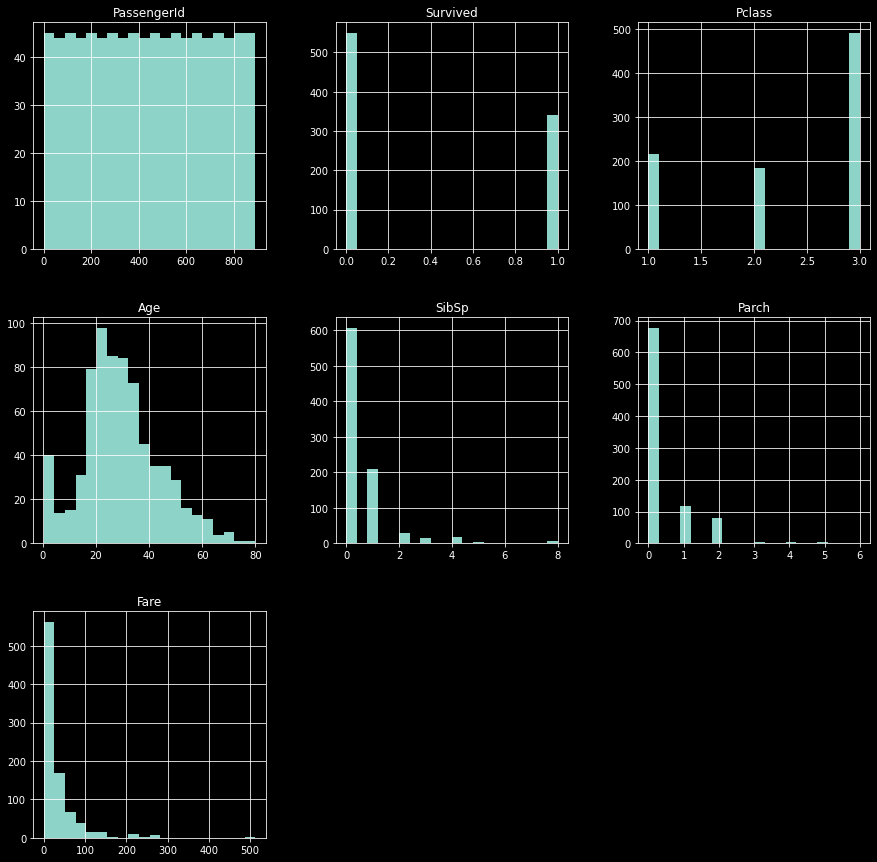

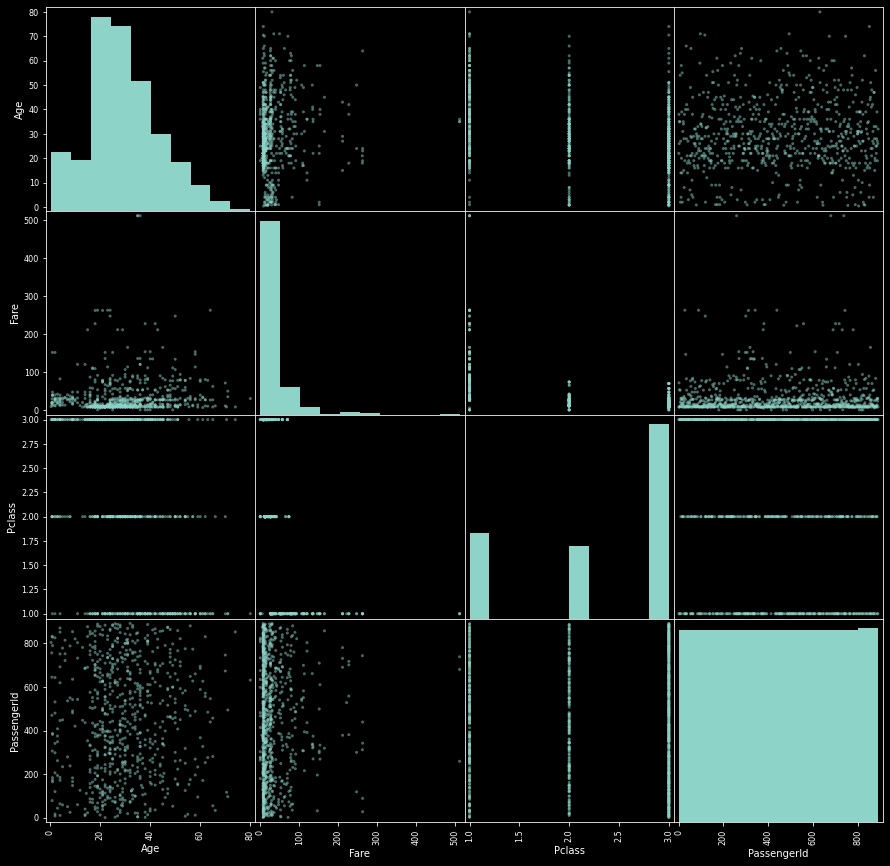

In [9]:
from pandas.plotting import scatter_matrix
data_set.hist(bins=20,figsize=(15,15))
plt.show()
scatter_matrix(data_set[["Age","Fare","Pclass","PassengerId"]],figsize=(15,15))
plt.show()

#### Some interesting thoughts:

1. There is no apparent relation between the PassengerId and Fare/Class. This could be for several reasons. Firstly, PassengerId could be assigned by the collectors of the dataset to identitify all passengers. Secondly, it could be because there is no apparent link between when the tickets were purchased and who got them. For now, I would like to conclude that there is no relation between "Fare" and "Pclass".
2. Interestingly, the cost of a certain class ticket is not the same for everyone. This is reflected in the range of fairs associated with each class. After further investigation, it is found that the better the class, the higher the fair and thus the larger the variation in cost. Also, it is interesting to see the imbalance in concentrations of age in the class.
3. There does seem to be a connection between PClass and Age. The younger the person is, the less wealthy, and hence the lower the class. 

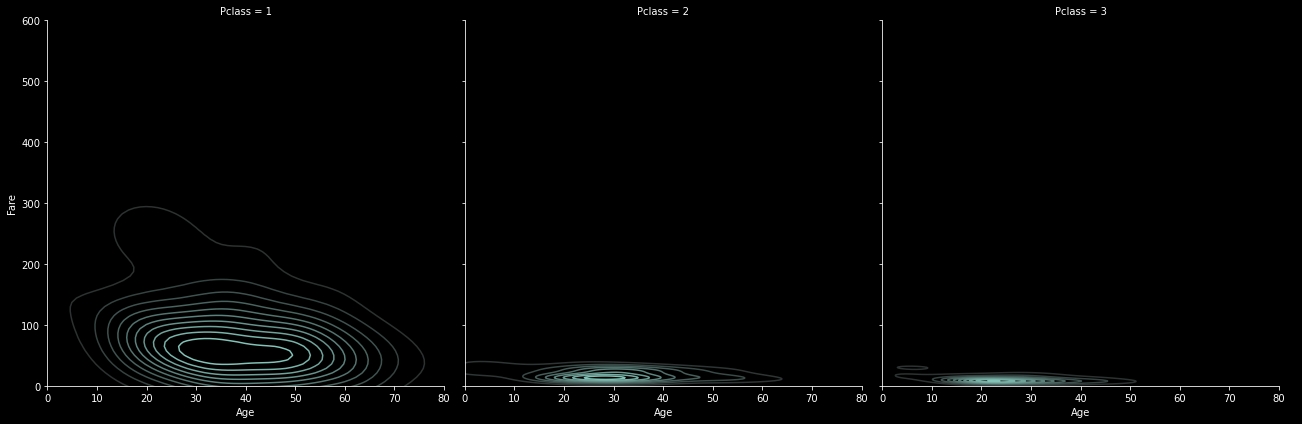

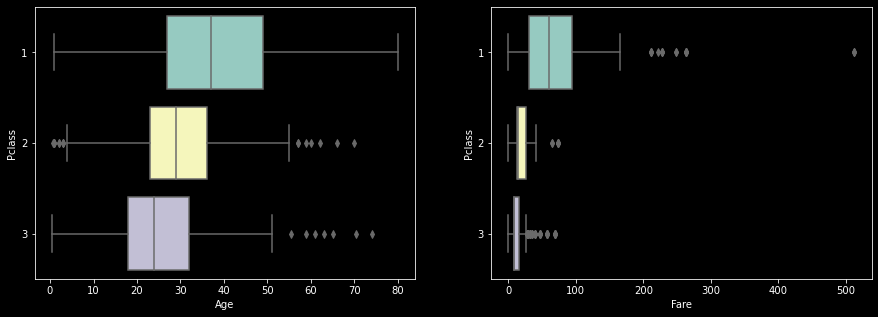

In [10]:
g = sns.FacetGrid(data_set,col="Pclass",size=6,xlim=(0,80),ylim=(0,600))
g = g.map(sns.kdeplot,"Age","Fare")
g.add_legend()
plt.show()
f,axes = plt.subplots(1,2,figsize=(15,5))
f = sns.boxplot(data=data_set,x='Age',y='Pclass',orient='h',ax=axes[0])
f = sns.boxplot(data=data_set,x='Fare',y='Pclass',orient='h',ax=axes[1])
plt.show()

### Correlation
Let us check what the correlation between different features is:

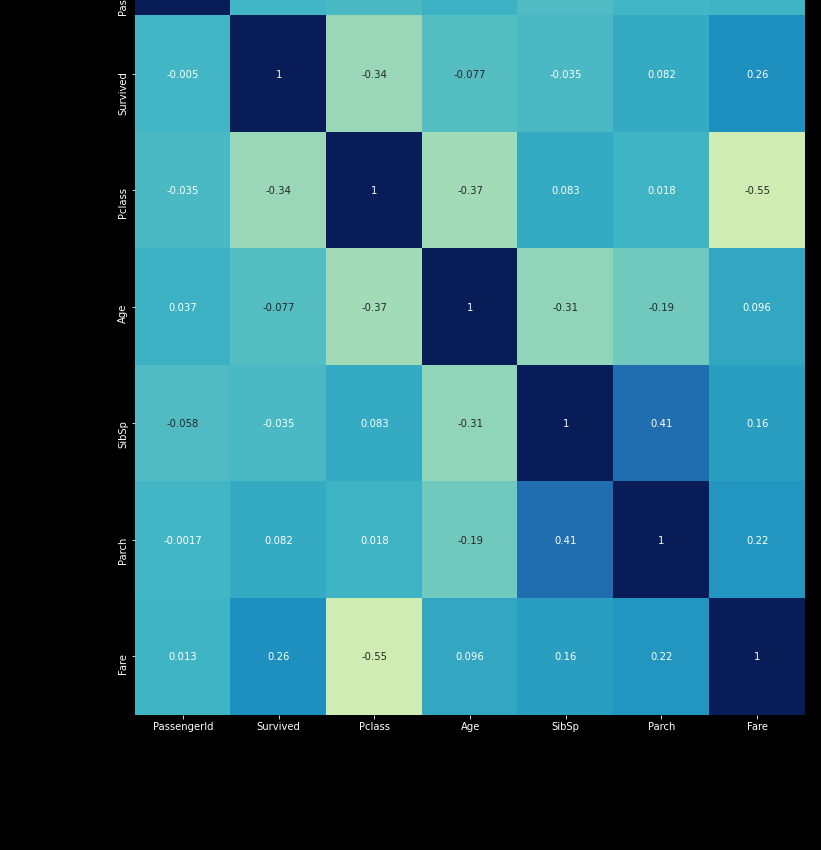

In [11]:
correlation_matrix = data_set.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix,annot=True,vmin=-1,vmax=1,cmap='YlGnBu')
plt.show()

Lets look at the features which are most correlated:

1. **Pclass and Fare** - Naturally, the higher the class (i.e. smaller the number), the more expensive it is.
2. **SibSp and Parch** - This makes sense. If you have a spouse on board, then your children might be one as well, and if you have siblings on board, then you are likely to be a child and have your parents on board

As PClass is weakly correlated with age, I decided to check survival rates by passenger class of different age groups.

In [12]:
data_set
men = data_set.loc[data_set.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [13]:
print(type(data_set))
print(sum(data_set['Survived']), ' survived / ', len(data_set), ' total passengers\n\n')
mclasscount, mclasssurv = np.zeros(3), np.zeros(3)
fclasscount, fclasssurv = np.zeros(3), np.zeros(3)
magecount, magesurv = np.zeros(4), np.zeros(4)
fagecount, fagesurv = np.zeros(4), np.zeros(4)
for i in range (len(data_set)):
    if data_set['Sex'][i] == 'male':
        temp_class = data_set['Pclass'][i] - 1
        mclasscount[temp_class] = mclasscount[temp_class] + 1
        mclasssurv[temp_class] = mclasssurv[temp_class] + data_set['Survived'][i]

        if data_set['Age'][i] <= 16:
            magecount[0] = magecount[0] + 1
            magesurv[0] = magesurv[0] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 25:
            magecount[1] = magecount[1] + 1
            magesurv[1] = magesurv[1] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 40:
            magecount[2] = magecount[2] + 1
            magesurv[2] = magesurv[2] + data_set['Survived'][i]
        else:
            magecount[3] = magecount[3] + 1
            magesurv[3] = magesurv[3] + data_set['Survived'][i]

    elif data_set['Sex'][i] == 'female':
        temp_class = data_set['Pclass'][i] - 1
        fclasscount[temp_class] = fclasscount[temp_class] + 1
        fclasssurv[temp_class] = fclasssurv[temp_class] + data_set['Survived'][i]

        if data_set['Age'][i] <= 16:
            fagecount[0] = fagecount[0] + 1
            fagesurv[0] = fagesurv[0] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 25:
            fagecount[1] = fagecount[1] + 1
            fagesurv[1] = fagesurv[1] + data_set['Survived'][i]
        elif data_set['Age'][i] <= 40:
            fagecount[2] = fagecount[2] + 1
            fagesurv[2] = fagesurv[2] + data_set['Survived'][i]
        else:
            fagecount[3] = fagecount[3] + 1
            fagesurv[3] = fagesurv[3] + data_set['Survived'][i]

#print('\nMale survival rate by class', mclasssurv / mclasscount)
#print('\nFemale survival rate by class', fclasssurv / fclasscount)

pclass_sex_array = pd.DataFrame([mclasssurv/mclasscount, fclasssurv/fclasscount], columns = ['1','2','3'], index = ['M', 'F']);
print('Survival rate class/sex\n', pclass_sex_array, '\n\n')

age_sex_array = pd.DataFrame([magesurv/magecount, fagesurv/fagecount], columns = ['0-16','17-25','26-40','41+'], index=['M','F']);
print('Survival rate age/sex\n', age_sex_array)

<class 'pandas.core.frame.DataFrame'>
342  survived /  891  total passengers


Survival rate class/sex
           1         2         3
M  0.368852  0.157407  0.135447
F  0.968085  0.921053  0.500000 


Survival rate age/sex
        0-16     17-25     26-40       41+
M  0.431373  0.117188  0.220930  0.150442
F  0.673469  0.739726  0.802198  0.722772


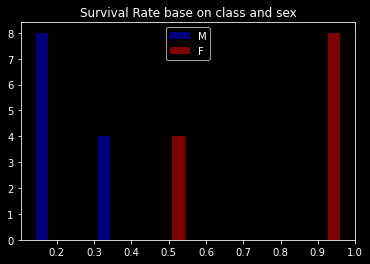

In [14]:
plt.hist([pclass_sex_array.loc['M'],pclass_sex_array.loc['F']],color=['b','r'], alpha=0.5,density=True,label=['M','F']) #Need better may of visuallizing
plt.legend()
plt.title("Survival Rate base on class and sex")
plt.show()

### Visualizing the results:
---

#### Pairplot
----


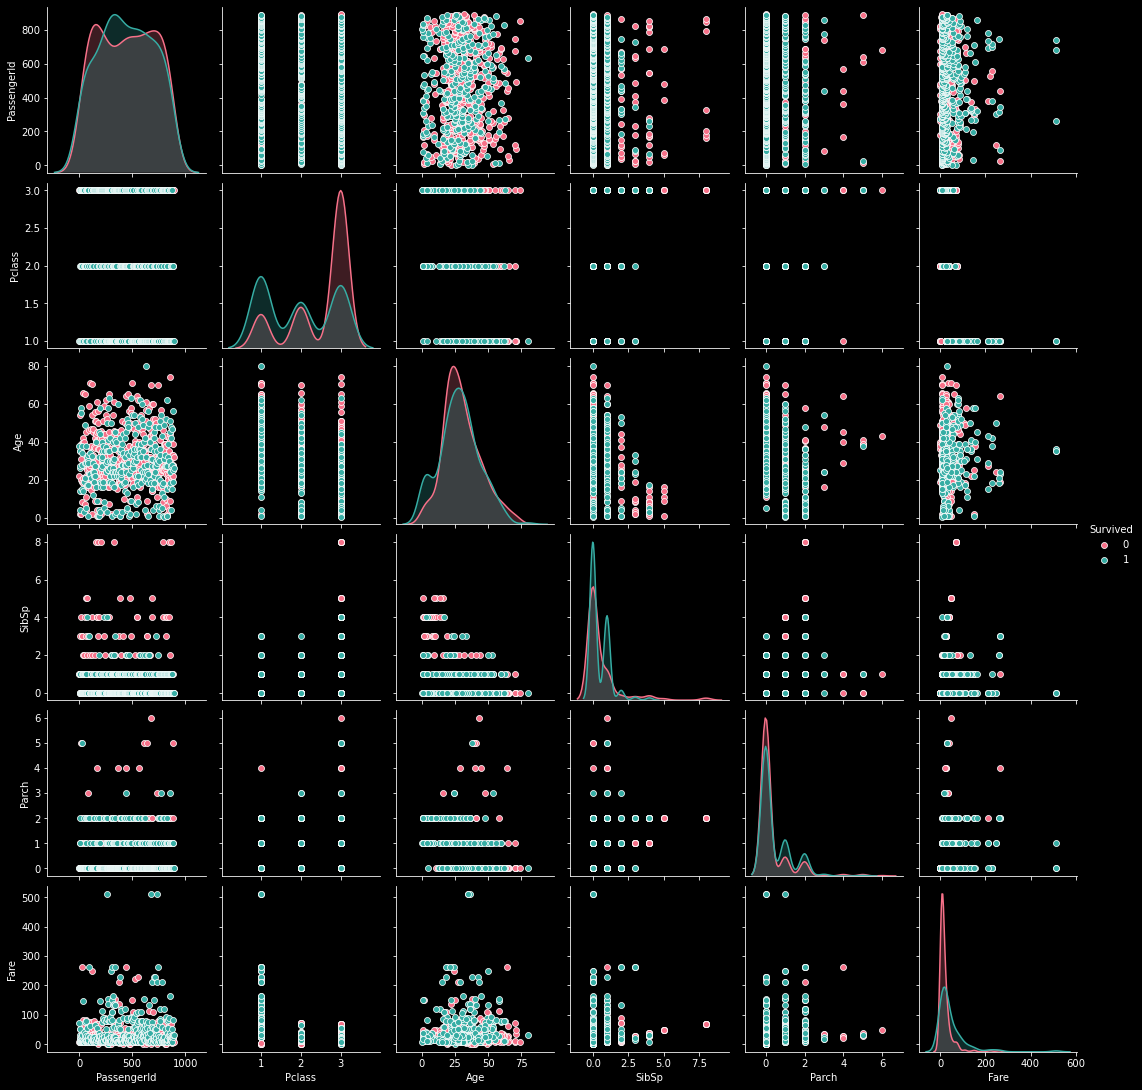

In [15]:
sns.pairplot(data_set,hue="Survived",palette="husl")

#### Cabin Feature
----

Here, we will try to investigate how to use the cabin feature, and what new feature can be engineered from it.

It may be a good idea to create a feature for the deck (letter) and then one for the room?

In [16]:
data_set['Cabin'].astype("string").value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
F33            3
D              3
              ..
A7             1
E38            1
C111           1
C106           1
E50            1
Name: Cabin, Length: 147, dtype: Int64

## Preparing data for algorithm
These are some initial steps taken to pre-process data.

---
### Remove unwanted features
I believe that **PassangerID** and **Name** will not be useful at the moment. Likewise, the **ticket** will not be used as lots of processing is required on it, and neither will **cabin** as only 1/4 of records have this information.

In [17]:
cat_selector = FeatureSelector(['Sex','Embarked', 'Pclass'])
num_selector = FeatureSelector(['Age','SibSp','Parch','Fare'])# should pclass be numerical or categorical? - I think it should be categorical (NN)
cat_selector.fit_transform(data_set)

array([['male', 'S', 3],
       ['female', 'C', 1],
       ['female', 'S', 3],
       ...,
       ['female', 'S', 3],
       ['male', 'C', 1],
       ['male', 'Q', 3]], dtype=object)

### Fix missing values

In [18]:
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

### Encoding categorical data

In [19]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

### Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
num_scalar = StandardScaler()

### Cabin transformations

In [21]:
from transformers.FeatureSelector import FeatureSelector
from transformers.FeatureMapper import FeatureMapper
from sklearn.preprocessing import OneHotEncoder
def get_deck(cabin):
    return str(cabin)[0]

cabin_selector = FeatureSelector(['Cabin'])
cabin_mapper = FeatureMapper(get_deck)
cabin_encoder = OneHotEncoder()


### Pipeline

In [22]:
from sklearn.pipeline import Pipeline,FeatureUnion
num_pipeline = Pipeline([('selector',num_selector),('imputer',num_imputer),('scalar',num_scalar)])
cat_pipeline = Pipeline([('selector',cat_selector),('imputer',cat_imputer),('encoder',cat_encoder)])
cabin_pipeline = Pipeline([('selector',cabin_selector),('mapper',cabin_mapper),('encoder',cabin_encoder)])
full_pipeline = FeatureUnion(transformer_list=[('num_pipeline',num_pipeline),('cat_pipeline',cat_pipeline),('cabin_pipeline',cabin_pipeline)])

### Splitting the data

In [23]:
data_set_X, data_set_Y = splitter.split_from_labels(data_set,label_names)

training_set, validation_set, test_set = splitter.split_tvt_set(data_set,[4,0,1],seed)
training_set_X, training_set_Y = splitter.split_from_labels(training_set,label_names)
test_set_X, test_set_Y = splitter.split_from_labels(test_set,label_names)

training_set_X_trans = full_pipeline.fit_transform(training_set_X)
test_set_X_trans = full_pipeline.fit_transform(test_set_X)

## Logistic regression

In [24]:
model = LogisticRegression(solver = 'liblinear', random_state=0)
#Will change parameters here according to data analysis
model.fit(training_set_X_trans, training_set_Y) 
y_pred = model.predict(test_set_X_trans)
print(model.score(test_set_X_trans, test_set_Y))

0.8190743338008415


## Support Vector Machine



In [25]:
svm = SVC()
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01,0.03,0.035,0.04,0.1,0.3,'auto','scale'],
                     'C': [60,65,70,80]}]
gd = GridSearchCV(svm,scoring='accuracy',param_grid=tuned_parameters)
gd.fit(training_set_X_trans,training_set_Y)
print(gd.best_params_)
gd.best_score_


{'C': 80, 'gamma': 0.01, 'kernel': 'rbf'}


0.8118388653599922

## Random Forests

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(training_set_X_trans,training_set_Y)  FOR NOW
print(rf_random.best_params_)
rf_random.best_score_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

# Yang's Solution

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron
from sklearn import svm
from sklearn.neural_network import MLPClassifier

#randomforest

round1a_rf = RandomForestClassifier(random_state = 1)
round1a_rf.fit(training_set_X_trans,training_set_Y)
a = round1a_rf.predict(test_set_X_trans)

#ridgeclassification
round1a_rc = RidgeClassifier(random_state=1)
round1a_rc.fit(training_set_X_trans,training_set_Y)
b = round1a_rc.predict(test_set_X_trans)

#svm
round1a_svm = svm.SVC(random_state=1)
round1a_svm.fit(training_set_X_trans, training_set_Y)
c = round1a_svm.predict(test_set_X_trans)


#MLPclassifier
round1a_mlp = MLPClassifier(random_state=1)
round1a_mlp.fit(training_set_X_trans, training_set_Y)
d = round1a_mlp.predict(test_set_X_trans)

#Perceptron
round1a_perc = Perceptron(random_state=1)
round1a_perc.fit(training_set_X_trans, training_set_Y)
e = round1a_perc.predict(test_set_X_trans)
#print(e)
#voting
vote = (((a+b+c+d+e)/5) > .5).astype(int)
print(len(vote), '\n', type(vote))
#votedf = pd.DataFrame(data=vote, columns = ['Survived'])
#votedf.to_excel('predictions.xlsx')


#print(vote.score(test_set_X_trans, test_set_Y))

713 
 <class 'numpy.ndarray'>


In [28]:
count = 0
#print(type(y_pred), y_pred.shape)
#print(type(test_set_Y), test_set_Y.shape)

#print(test_set_Y.head())
#for i in range(5):
    #print(test_set_Y[''][i])
arrayedtest = np.array(test_set_Y['Survived'])
#print(arrayedtest, type(arrayedtest))


for i in range(len(vote)):
    #print(y_pred[i], 'y_pred\n')
    #print(arrayedtest[i], 'test_set\n')
    if arrayedtest[i] == vote[i]:
        count = count + 1
print(count/len(vote))

#print(type(test_set_Y))

0.8611500701262272


# Final Classifier:

In [29]:

round1a_rf = RandomForestClassifier(random_state = 1)
round1a_rf.fit(training_set_X_trans,training_set_Y)
a = round1a_rf.predict(training_set_X_trans)

#ridgeclassification
round1a_rc = RidgeClassifier(random_state=1)
round1a_rc.fit(training_set_X_trans,training_set_Y)
b = round1a_rc.predict(training_set_X_trans)

#svm
round1a_svm = svm.SVC(random_state=1)
round1a_svm.fit(training_set_X_trans, training_set_Y)
c = round1a_svm.predict(training_set_X_trans)


#MLPclassifier
round1a_mlp = MLPClassifier(random_state=1)
round1a_mlp.fit(training_set_X_trans, training_set_Y)
d = round1a_mlp.predict(training_set_X_trans)

#Perceptron
round1a_perc = Perceptron(random_state=1)
round1a_perc.fit(training_set_X_trans, training_set_Y)
e = round1a_perc.predict(training_set_X_trans)

five_results = np.concatenate((a.reshape(-1,1),b.reshape(-1,1),c.reshape(-1,1),d.reshape(-1,1),e.reshape(-1,1)),axis=1)


print(five_results.shape)
print(training_set_Y.shape)
finalClassifier = MLPClassifier(random_state=1)
gd = GridSearchCV(finalClassifier,scoring='accuracy', param_grid={})
gd.fit(five_results,training_set_Y)




a = round1a_rf.predict(test_set_X_trans)
b = round1a_rc.predict(test_set_X_trans)
c = round1a_svm.predict(test_set_X_trans)
d = round1a_mlp.predict(test_set_X_trans)
e = round1a_perc.predict(test_set_X_trans)

pre_pred = np.concatenate((a.reshape(-1,1),b.reshape(-1,1),c.reshape(-1,1),d.reshape(-1,1),e.reshape(-1,1)),axis=1)
arrayedtest = np.array(test_set_Y['Survived'])
print(arrayedtest, type(arrayedtest))

gd.score(pre_pred,arrayedtest)


(712, 5)
(712, 1)
[1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1
 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1
 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0
 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1
 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1
 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0
 1 0 1 

0.8779803646563815

In [30]:
from sklearn.preprocessing import MaxAbsScaler



model = LogisticRegression(solver = 'liblinear', random_state=0)
#Will change parameters here according to data analysis
model.fit(training_set_X_trans, training_set_Y) 
y_pred = model.predict(test_set_X_trans)
print('Unscaled score: ', model.score(test_set_X_trans, test_set_Y))

scaler = MaxAbsScaler(False)
scaler.fit(training_set_X_trans)

X_train = scaler.transform(training_set_X_trans)
X_test = scaler.transform(test_set_X_trans)

model = LogisticRegression(solver = 'liblinear', random_state=0)
#Will change parameters here according to data analysis
model.fit(X_train, training_set_Y) 
y_pred = model.predict(X_test)
print('Scaled score: ', model.score(X_test, test_set_Y))



from sklearn.linear_model import LogisticRegression
Pipeline([('classifier' , LogisticRegression())])
model1 = LogisticRegression()
param_grid = [{'C': [10.0, 100.0, 1000.0], 'gamma': [0.001, 0.0001]}]
gd1 = GridSearchCV(model1,scoring='accuracy', param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
gd1.fit(training_set_X_trans,training_set_Y)
print(gd.best_params_)
gd1.best_score_

Unscaled score:  0.8190743338008415
Scaled score:  0.820476858345021
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ValueError: Invalid parameter gamma for estimator LogisticRegression(C=10.0). Check the list of available parameters with `estimator.get_params().keys()`.

TypeError: get_params() missing 1 required positional argument: 'self'

In [31]:
optimisation = GridSearchCV()
parameters = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [1,2,3,300,500]}
search_model = optimisation(LogisticRegression(), scoring = 'accuracy', param_grid = parameters)
search_model.fit(training_set_X_trans, training_set_Y)
y_pred_acc = search_model.predict(test_set_X_trans)
print(model.score(test_set_X_trans, test_set_Y))

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_grid'

## Locally Weighted Regression


In [32]:
tau = 0.005

def bell_curve(xi,x0): 
    return np.exp( - (xi - x0)**2/(2*tau))

def LocallyWeightedRegression(x, y):
    m = np.shape(x)[1]
    n = len(y)
    yest = np.zeros(n)

    w = []
    for i in range(m):
        for j in range(n):
            w[i, j] = np.exp(- (x[j] - x[i])**2/(2*tau))
    
    # This isn't quite right yet but I will fix it
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights*y), np.sum(weights*y*x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)], [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[i]*x[i]

    return yest

y_loc_reg_pred = LocallyWeightedRegression(training_set_X_trans, training_set_Y)
for j in range(len(y_loc_reg_pred)):
    print(y_loc_reg_pred[j])

TypeError: matrix is not square

### Deep Learning

In [140]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
training_X_tensor = torch.from_numpy(training_set_X_trans.toarray()).float().to(device)
training_Y_tensor = torch.from_numpy(training_set_Y.to_numpy()).float().to(device)

test_X_tensor = torch.from_numpy(test_set_X_trans.toarray()).float().to(device)
test_Y_tensor = torch.from_numpy(test_set_Y.to_numpy()).float().to(device)
from torch.utils.data import TensorDataset, DataLoader

trainDataSet = TensorDataset(training_X_tensor,training_Y_tensor)
trainDataLoader = DataLoader(trainDataSet,batch_size=4,drop_last=True,num_workers=0)

testDataSet = TensorDataset(test_X_tensor,test_Y_tensor)
testDataLoader = DataLoader(testDataSet,batch_size=4,drop_last=True,num_workers=0)

cuda:0


In [127]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(21,1)
        
    def forward(self,x):
        return F.sigmoid(self.l1(x))
net = nn.Sequential(nn.Linear(21,21),nn.ReLU(),nn.Linear(21,1),nn.Sigmoid())
print(net)

Sequential(
  (0): Linear(in_features=21, out_features=21, bias=True)
  (1): ReLU()
  (2): Linear(in_features=21, out_features=1, bias=True)
  (3): Sigmoid()
)


In [135]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts 
from torch.optim import SGD

def train(trainloader,model,epochs,lr_init=1,t_0=200,t_mult=1):
    optimizer = SGD(model.parameters(),lr_init,momentum=0.8,nesterov=True)
    #torch.optim.Adam(model.parameters(),lr_init)
    scheduler = CosineAnnealingWarmRestarts(optimizer, t_0,t_mult)
    criterion = nn.BCEWithLogitsLoss()
    loses = []
    for epoch in range(epochs):
        running_loss = 0
        for i,data in enumerate(trainloader):
            x,y = data
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred,y)
            running_loss += loss
            loss.backward()

            optimizer.step()
        loses.append(running_loss)
        scheduler.step()
        print(epoch+1)
    return loses


In [136]:
def accuracy(testloader,model):
    count = 0
    total = len(testloader.dataset)
    for data in testloader:
        input, label = data[0],data[1]
        pred = model(input)
        count += ((pred>=0.5).int()==label).sum().item()
    return count/total



In [137]:
def loss(testloader,model,criterion):
    loss = 0
    for data in testloader:
        x,y = data[0],data[1]
        pred = model(x)
        loss += criterion(pred,y)
    return loss

In [138]:
def debugTrainer(trainer,epochs=100):
    x = range(1,epochs+1)
    y = trainer(epochs)
    plt.plot(x,y)
    plt.show()
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


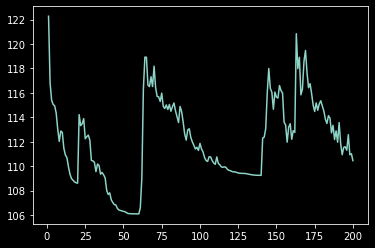

0.8258426966292135
0.7685834502103787


In [142]:
net = nn.Sequential(nn.BatchNorm1d(21),nn.Linear(21,63),nn.ReLU(),nn.BatchNorm1d(63),nn.Linear(63,63),nn.ReLU(),nn.BatchNorm1d(63),nn.Linear(63,63),nn.ReLU(),nn.BatchNorm1d(63),nn.Linear(63,1),nn.Sigmoid()).to(device)
debugTrainer((lambda epochs: train(trainDataLoader,net,epochs,0.1,20,2)),200)
#debugTrainer((lambda epochs: train(trainDataLoader,net,epochs,0.1,0.99)),500)
#debugTrainer((lambda epochs: train(trainDataLoader,net,epochs,0.05,0.995)),1000)
#debugTrainer((lambda epochs: train(trainDataLoader,net,epochs,0.001,0.995)),500)

print(accuracy(trainDataLoader,net))
print(accuracy(testDataLoader,net))

# Final Predictions:
---

In [49]:
final_test_set = pd.read_csv(test_set_path)
fdata = full_pipeline.transform(final_test_set)


In [50]:
def createPrediction(predictions):
    predictions = model.predict(fdata).reshape(-1,1)
    ids = final_test_set["PassengerId"].to_numpy().reshape(-1,1)
    output_data = np.concatenate((ids,predictions),axis=1)
    df = pd.DataFrame(data=output_data,columns =["PassengerId","Survived"])
    df.to_csv(output_path,index=False)


In [51]:

a = round1a_rf.predict(fdata)
b = round1a_rc.predict(fdata)
c = round1a_svm.predict(fdata)
d = round1a_mlp.predict(fdata)
e = round1a_perc.predict(fdata)

vote = (((a+b+c+d+e)/5) > .5).astype(int)


### Deep Learning output

In [52]:
fdata_tensor = torch.from_numpy(fdata.toarray()).float()
createPrediction(net(fdata_tensor).detach().numpy())